# 14. Runge-Kutta method, Version 3; Vectorization; Writing your own module

Now that we are introduced to numpy arrays and know that we can use them to quickly perform vector operations, let's implement numpy arrays in our Runge-Kutta method to make it more general and concise.

We'll replace every occurence of $xpos, xvel, zpos, zvel$ with the vector $y$, represented in python by a numpy array. Similarly, we'll replace every occurence of $xvel, xacc, zvel, zacc$ with $ydot$. Don't forget to use np.array() so that the vectors can be operated on as a whole.

### ✏️ Checkpoint: Thinking in Vectors

We are about to rewrite the projectile code so that instead of four separate variables `(xpos, xvel, zpos, zvel)`, we use a single vector `y`.

**Q1.** If `y = np.array([xpos, xvel, zpos, zvel])`, what should `ydot` (the time derivative of `y`) contain? Write out all four components.

**Q2.** Using `y` and `ydot`, write the Euler update step in one line of math/code.

**Q3.** Why is the vectorized form more *general*? What would you change in `diffeq` to track a second particle?

*Write your answers below, then implement the vectorized `diffeq()` in the next cell.*

In [2]:
# Checkpoint answers
# Q1: ydot = [
#        ,   # d(xpos)/dt = xvel
#        ,   # d(xvel)/dt = -b*xvel
#        ,   # d(zpos)/dt = zvel
#        ]   # d(zvel)/dt = -g-b*zvel
# Q2: y = y + ydot*dt
# Q3: Coords need to be in the state vector y

In [3]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.8   # m/s²
mass = 0.1  # kg
b = 1       # 1/s

# TODO: Rewrite diffeq to accept a single numpy array y and return ydot.
# y    = [xpos, xvel, zpos, zvel]
# ydot = [d(xpos)/dt, d(xvel)/dt, d(zpos)/dt, d(zvel)/dt]
#       = [xvel,      xacc,       zvel,        zacc      ]

def diffeq(y):
    xpos, xvel, zpos, zvel = y # unpack state vector

    xacc = -b*xvel   # horizontal acceleration (drag only)
    zacc = -g-b*zvel   # vertical acceleration (gravity + drag)

    # Build ydot in the same order as y: [xpos-dot, xvel-dot, zpos-dot, zvel-dot]
    ydot = np.array([xvel, xacc, zvel, zacc])
    return ydot

zEuler = []; xEuler = []
zRK2   = []; xRK2   = []


In [4]:
# Euler's method in vectorized form — complete for reference
def move_Euler(y):
    ydot = diffeq(y)
    y = y + ydot * dt
    return y

# TODO: Complete the vectorized RK2.
# Hint: each stage is now a single line operating on the whole vector.
def move_RK2(y):
    # Stage 1: derivatives at current time t
    ydot   =  diffeq(y)

    # Stage 2: estimate state at t + dt/2
    y_half    = y + ydot * dt/2
    ydot_half = diffeq(y_half)

    # Stage 3: update to t + dt using midpoint derivatives
    y = y + ydot_half * dt
    return y

In [5]:
# --- Euler reference (tiny dt) ---
dt = 0.0001
t_max = 20.0
y = np.array([0.0, 3.0, 0.0, 10.0])  # xpos, xvel, zpos, zvel

t = 0.0
while t < t_max:
    y = move_Euler(y)
    if y[2] < 0:
        break
    zEuler.append(y[2])
    xEuler.append(y[0])
    t += dt

# --- RK2 (larger dt) ---
# Reinitialize and use a while loop so RK2 steps at its own dt
dt = 0.1
y = np.array([0.0, 3.0, 0.0, 10.0])

t = 0.0
while t < t_max:
    y = move_RK2(y)
    if y[2] < 0:
        break
    zRK2.append(y[2])
    xRK2.append(y[0])
    t += dt


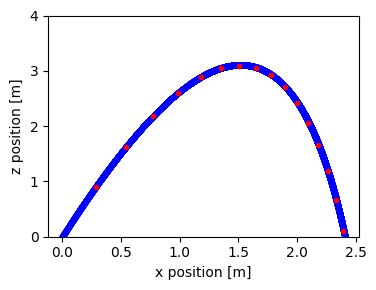

In [6]:
fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(xEuler, zEuler, 'b.')
ax.plot(xRK2, zRK2 , 'r.')

ax.set_ylim(0, 4)
ax.set_ylabel('z position [m]')
ax.set_xlabel('x position [m]')
plt.tight_layout()
plt.show()

Notice that, at this point, our ODE solver is abstract and general enough to apply to **any** problem, no matter how many dimesions or particles there are. All that the move_Euler() and move_RK2() functions can see is an abstract vector called $y$. And it's up to us to design what $y$ really means outside these functions.

For this reason, we can actually completely separate these ODE solvers outside the current script. Let's cut away the following parts and put them into a separate python file called myode.py

In [7]:
%%writefile myode.py
# myode.py — general-purpose ODE solvers
# Functions accept: f (the diffeq function), y (state vector), dt (timestep)

def move_Euler(f, y, dt):
    ydot = f(y)      # call the passed-in diffeq function
    y    = y + ydot * dt         # Euler update (one line)
    return y

def move_RK2(f, y, dt):
    ydot      = f(y)              # derivatives at time t
    y_half    = y + ydot * dt/2           # propagate to midpoint t + dt/2
    ydot_half = f(y_half)       # evaluate diffeq at midpoint
    y         = y + ydot_half * dt      # update to t + dt
    return y


Writing myode.py


There - you've just written your first module! After that, in our project code version 3, we can import the module you just wrote just like other modules like numpy, using "import \[name of your module exluding the .py extension\]". For example, import myode

The final script looks like the following, and should generate the exact same figure.

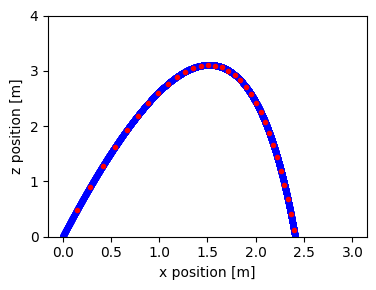

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import myode

g = 9.8 # in m/s2

zEuler = []
xEuler = []
zRK2 = []
xRK2 = []

mass = 0.1 # in kg
b = 1 # in units of 1/s

def diffeq( y ):
    xpos, xvel, zpos, zvel = y
    zacc = -g-b*zvel
    xacc = -b*xvel
    ydot = np.array( [xvel, xacc , zvel, zacc])
    return ydot

#Euler
dt = 0.0001
t_range = np.arange(0,20,dt)
y = np.array([0, 3, 0 ,10 ])

for t in t_range:
    y = myode.move_Euler(diffeq, y,dt)
    zEuler.append(y[2])
    xEuler.append(y[0])

#RK2
# reinitialize positions and velocities for the second solution
dt = 0.05
t_range = np.arange(0,20,dt)
y = np.array([0, 3, 0 ,10 ])

for t in t_range:
    y = myode.move_RK2(diffeq, y,dt)
    zRK2.append(y[2])
    xRK2.append(y[0])

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(xEuler, zEuler, 'b.')
ax.plot(xRK2, zRK2 , 'r.')

ax.set_ylim(0, 4)
ax.set_ylabel('z position [m]')
ax.set_xlabel('x position [m]')
plt.tight_layout()
plt.show()

**Common error 1**: Make sure that current working directory contains both your current RK2 script and the myode.py. Otherwise Spyder will complain that it cannot find your myode module.

**Common error 2**: If you see an error message like
<div class="span alert alert-warning">
UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
</div>
you probably have a line like
<div class="span alert alert-warning">
y += ydot * dt
</div>
in your myode.py.  If you expand it back to
<div class="span alert alert-warning">
y = y + ydot * dt
</div>
the error will be resolved. This is very subtle error: Why is it that $x += 1 $ works for scalars but not on numpy arrays? To answer this we'll have to use concepts that appear later in the course, so it's okay to skip this for now. If you're curious, here it goes. Turns out that "+" and "+=" are two different methods. When we write y += ydot * dt, it means to carry out the right-hand-side operation and modify the contents of the left-hand-side's memory. So if your y vector starts out containing only integers like [0,3,0,10], then changing that into floats it not something numpy likes, therefore numpy throw an error. If you do y = y + ydot * dt, the RHS operation produces a result that is assigned to a new location in memory, which is allowed.

For more details see [this link](https://stackoverflow.com/questions/35910577/why-does-python-numpys-mutate-the-original-array).

## In-Class Group Project

Now that we have a general ODE solver in `myode.py`, let's apply it.

A projectile starts from the origin with speed **|v| = 30 m/s**. Air drag coefficient b = 1 /s, g = 9.8 m/s².

---

### Step 1 — Set Up and Test
Define `diffeq(y)` for this problem and choose an initial angle. Run a trajectory and plot it to confirm your setup is working.

### Step 2 — Problem 1: Hit a Target
Find the launch angle (in degrees) needed to land the projectile at ground level exactly **20 m** from the origin.

*Strategy hint:* Write a function `final_x(angle)` that runs the simulation and returns the x-position when z first crosses zero. Then search for the angle that makes `final_x(angle) ≈ 20`.

### Step 3 — Problem 2: Maximize Range
Find the angle that achieves the greatest horizontal range.

*Strategy hint:* Call `final_x(angle)` for many angles and find the maximum. Plot range vs. angle to visualize the result.

### Step 4 — Reflect
- How does the optimal angle compare to the 45° prediction from drag-free physics? Why is it different?
- What happens to the optimal angle as you increase `b`? Try b = 0, 0.5, 1, 2.

*Record your results and reasoning in markdown cells as you work.*

Target x at 45.0°: 20.17 m
Angle to hit 20.0m: 12.8°
Max range: 23.47 m at 27.1°


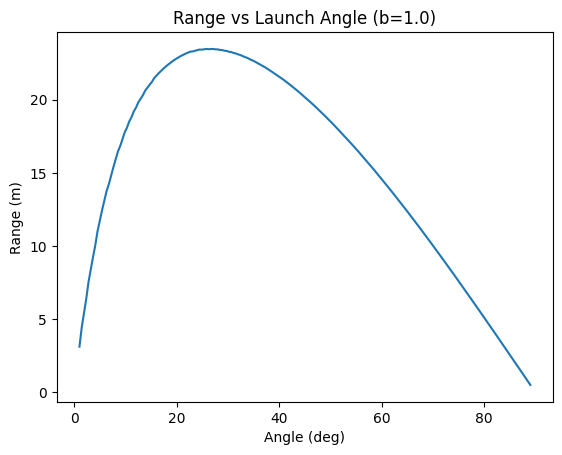

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import myode

g = 9.8
b = 1.0
speed = 30.0

def diffeq(y):
    """Equations of motion for projectile with linear air drag."""
    xpos, xvel, zpos, zvel = y
    xacc = -b*xvel
    zacc = -g-b*zvel
    return np.array([xvel, xacc, zvel, zacc])

def final_x(angle_deg, speed=30.0, dt=0.01):
    """Return the x-position when the projectile hits the ground (z <= 0)."""
    angle = np.radians(angle_deg)
    y = np.array([0.0, speed*np.cos(angle), 0.0, speed*np.sin(angle)])
    while y[2] >= 0:        # run until projectile hits the ground
        y = myode.move_RK2(diffeq, y, dt)
    return y[0] # TODO: return the x-position at landing

# --- Step 1: test one trajectory ---
# Choose an angle, run the simulation, and plot the trajectory to confirm it works.
angle = 45.0
print(f"Target x at {angle}°: {final_x(angle):.2f} m")

# --- Step 2: find angle to hit target at x = 20 m ---
# Hint: loop over a range of angles, call final_x(angle), find where it equals 20.
target_x = 20.0
angles = np.linspace(1, 89, 180)
ranges = [final_x(a) for a in angles]
best_angle = angles[np.argmin(np.abs(np.array(ranges) - target_x))]
print(f"Angle to hit {target_x}m: {best_angle:.1f}°")

# --- Step 3: maximize range ---
# Hint: call final_x(angle) for many angles and find the maximum.
# Plot range vs. angle to visualize.
angles = np.linspace(1, 89, 200)
ranges = [final_x(a) for a in angles]
max_range = np.max(ranges)
max_angle = angles[np.argmax(ranges)]
print(f"Max range: {max_range:.2f} m at {max_angle:.1f}°")
plt.plot(angles, ranges)
plt.xlabel("Angle (deg)")
plt.ylabel("Range (m)")
plt.title("Range vs Launch Angle")
plt.show()


In [ ]:
# --- Step 4: reflect ---
# How does the optimal angle compare to the 45° prediction from drag-free physics? Why is it different?
# What happens to the optimal angle as you increase b? Try b = 0, 0.5, 1, 2.
#
# 1. Angle theta < 45°, speed gets reduced the longer the ball is in the air due to drag, smaller angles have a shorter flight time
# 2. As b increases, optical angle decreases, at b = 0, the angle is 45°.
